In [54]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6000)]
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

tf.keras.config.enable_interactive_logging()

1 Physical GPU, 1 Logical GPUs


# Step 1
load the eyes detection model and find the eyes in the image

In [55]:
# Load the eyes detection model
model = tf.keras.models.load_model('./models/facial_landmark_detection.h5')

find the eyes in the image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
[[699.8488  603.3432  330.43753 620.1949  628.299   612.04156 777.5154
  606.0701  410.2596  625.1077  264.442   643.5037 ]]


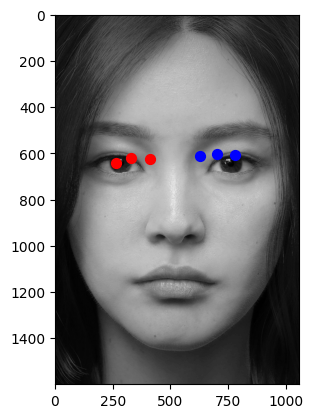

In [56]:
image_path = './dataset/test_face_3.jpg'
test_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
initial_image = test_image.copy()
initial_shape = test_image.shape

# resize the image to 96x96 to match the input size of the model
model_input_shape = (96, 96)
test_image = cv2.resize(test_image, model_input_shape)
test_image = np.expand_dims(test_image, axis=2)
    
test_landmarks = model.predict(test_image.reshape(1, model_input_shape[0], model_input_shape[1], 1) / 255.0)

# convert the landmarks to the correct format
test_landmarks[0, 0::2] = test_landmarks[0, 0::2] * initial_shape[1] / model_input_shape[1]
test_landmarks[0, 1::2] = test_landmarks[0, 1::2] * initial_shape[0] / model_input_shape[0]

right_eye_landmarks = [test_landmarks[0][8], test_landmarks[0][9], test_landmarks[0][2], test_landmarks[0][3], test_landmarks[0][10], test_landmarks[0][11]]
left_eye_landmarks = [test_landmarks[0][4], test_landmarks[0][5], test_landmarks[0][0], test_landmarks[0][1], test_landmarks[0][6], test_landmarks[0][7]]

print(test_landmarks)

plt.imshow(initial_image, cmap='gray')
plt.scatter(right_eye_landmarks[0::2], right_eye_landmarks[1::2], c='r', s=50)
plt.scatter(left_eye_landmarks[0::2], left_eye_landmarks[1::2], c='b', s=50)
plt.show()

# Step 2
Extract the eyes from the image

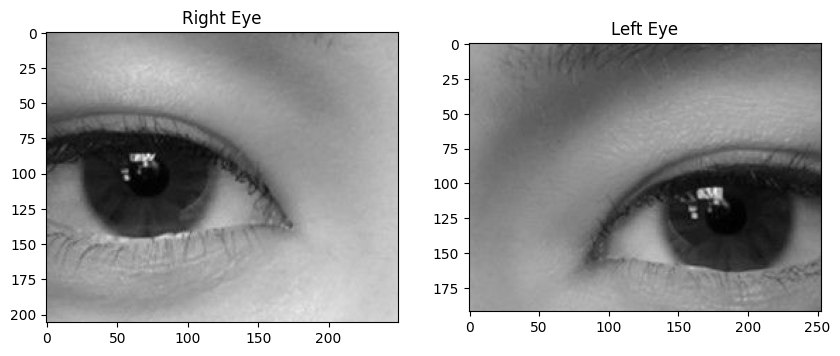

In [57]:
def extract_eyes(image_path, right_eye_landmarks, left_eye_landmarks):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # get the min and max x and y coordinates for the eyes
    left_eye_x_min = int(min(left_eye_landmarks[0], left_eye_landmarks[2], left_eye_landmarks[4]))
    left_eye_x_max = int(max(left_eye_landmarks[0], left_eye_landmarks[2], left_eye_landmarks[4]))
    left_eye_y_min = int(min(left_eye_landmarks[1], left_eye_landmarks[3], left_eye_landmarks[5]))
    left_eye_y_max = int(max(left_eye_landmarks[1], left_eye_landmarks[3], left_eye_landmarks[5]))
    
    right_eye_x_min = int(min(right_eye_landmarks[0], right_eye_landmarks[2], right_eye_landmarks[4]))
    right_eye_x_max = int(max(right_eye_landmarks[0], right_eye_landmarks[2], right_eye_landmarks[4]))
    right_eye_y_min = int(min(right_eye_landmarks[1], right_eye_landmarks[3], right_eye_landmarks[5]))
    right_eye_y_max = int(max(right_eye_landmarks[1], right_eye_landmarks[3], right_eye_landmarks[5]))
    
    correction_factor_x = int(image.shape[1] * 0.05)
    correction_factor_y = int(image.shape[0] * 0.05)
    
    height = max(right_eye_y_max - right_eye_y_min, left_eye_y_max - left_eye_y_min)
    
    # extract the eyes from the image
    left_eye_image = image[left_eye_y_min - correction_factor_y:left_eye_y_max + correction_factor_y + height, left_eye_x_min - correction_factor_x:left_eye_x_max + correction_factor_x]
    right_eye_image = image[right_eye_y_min - correction_factor_y:right_eye_y_max + correction_factor_y + height, right_eye_x_min - correction_factor_x:right_eye_x_max + correction_factor_x]
    
    return left_eye_image, right_eye_image

left_eye, right_eye = extract_eyes(image_path, right_eye_landmarks, left_eye_landmarks)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[1].imshow(left_eye, cmap='gray')
ax[1].set_title('Left Eye')

ax[0].imshow(right_eye, cmap='gray')
ax[0].set_title('Right Eye')
plt.show()

# Step 3
Load the iris tracker model and track the iris in the eyes

In [58]:
model = tf.keras.models.load_model('./models/iris_tracker_residual.h5')

Track the iris in the eyes

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


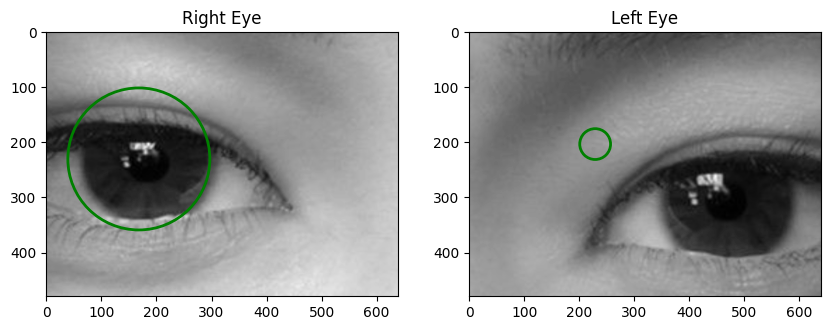

In [59]:
def predict_iris(image, model_input_shape=(75, 100)):
    pred = model.predict(image.reshape(1, model_input_shape[0], model_input_shape[1], 1))
    return pred[0]

initial_shape = (480, 640)
pred_left = predict_iris(cv2.resize(left_eye, (100, 75)) / 255.0)
pred_right = predict_iris(cv2.resize(right_eye, (100, 75)) / 255.0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[1].imshow(cv2.resize(left_eye, (initial_shape[1], initial_shape[0])), cmap='gray')
ax[1].set_title('Left Eye')

ax[0].imshow(cv2.resize(right_eye, (initial_shape[1], initial_shape[0])), cmap='gray')
ax[0].set_title('Right Eye')

circle_left = plt.Circle((int(pred_left[0]), int(pred_left[1])), int(pred_left[2]), color='g', fill=False, linewidth=2)
circle_right = plt.Circle((int(pred_right[0]), int(pred_right[1])), int(pred_right[2]), color='g', fill=False, linewidth=2)

ax[1].add_artist(circle_left)
ax[0].add_artist(circle_right)

plt.show()